## Abstract

 1. We are trying different imputation methods on the Titanic Dataset, and evaluating classifier accuracies for each of these. A package that we are using is fancyimpute.
 
 2. To briefly describe how gradient boosting differs from bagging.To implement gradient boosting as invoked in scikit-learn, and to evaluate classifier accuracy for the Titanic dataset. 
 
 3. To theoretically, increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability. Hence to design and evaluate a computational experiment to test this, on the Titanic dataset.
 
 4. To Pick any Kaggle regression dataset. Train, tune and evaluate performance of a Random Forest Regression model and to use the feature importance calculations from this to perform feature selection and to demonstrate this using the Kaggle regression dataset that has been picked.

## About the dataset "House Prices"

We are given a data set of 1,460 homes, each with a few dozen features of types: float, integer, and categorical. We are tasked with building a regression model to estimate a home's sale price. 
I'm going to use this problem as a way to explore common classifiers, namely:

random trees and
random forests.


## Loading the libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # some plotting!
import seaborn as sns # so pretty!
from scipy import stats # I might use this
from sklearn.ensemble import RandomForestClassifier # checking if this is available
# from sklearn import cross_validation
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory





In [4]:
# import the training data set and make sure it's in correctly...
train = pd.read_csv('train-2.csv')
train_original = pd.read_csv('train-2.csv')
test = pd.read_csv('test-2.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Feature First Impressions

It looks like we have integer, float, and object (categorical) features. Also, it looks like some of the features only pertain to a small portion of the 1,460 samples. For now, let's ignore those features where data is missing.

## Pre-processing Categorical Features

Let's declare a quick function to convert categorical features into integer features, with the most common category of the feature being converted to integer 0, the next most common to 1, and so on. This may be useful later.

In [5]:
# define a function to convert an object (categorical) feature into an int feature
# 0 = most common category, highest int = least common.
def getObjectFeature(df, col, datalength=1460):
    if df[col].dtype!='object': # if it's not categorical..
        print('feature',col,'is not an object feature.')
        return df
    elif len([i for i in df[col].T.notnull() if i == True])!=datalength: # if there's missing data..
        print('feature',col,'is missing data.')
        return df
    else:
        df1 = df
        counts = df1[col].value_counts() # get the counts for each label for the feature
        df1[col] = [counts.index.tolist().index(i) for i in df1[col]] # do the conversion
        return df1 # make the new (integer) column from the conversion
# and test the function...
fcntest = getObjectFeature(train,'LotShape')
fcntest.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## Target Variable Analysis: Is it Normal?

So let's take a look at the Sale Price data and check for normality, and try to correct it otherwise...

#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

So, certainly not normal: we have right-skewness and the data is a bit peak-y. Let's apply a log transform on the data and see what happens

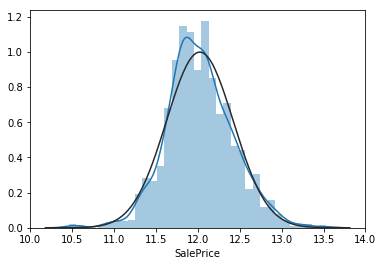

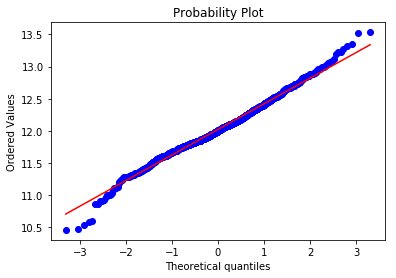

In [7]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

## A Better Fit!
That looks much more normal, which will hopefully improve the regressions. We just have to remember to transform the output data back using an exponentiation before we submit anything.

## First things first: A Random Tree Regressor

To start off, let's try to train a simple model using ONLY the features on the "benchmark" solution provided with the data for this competition. Those features are:

Year and month of sale,
Lot square footage, and
Number of bedrooms.
We will go for a very simple decision tree regression first. We can test for performance and overfitting using k-fold validation; here we take  k=10
 . First, we take the data and make it useful...

In [8]:
from sklearn.tree import DecisionTreeRegressor as dtr
# define the training data X...
X = train[['MoSold','YrSold','LotArea','BedroomAbvGr']]
Y = train[['SalePrice']]
# and the data for the competition submission...
X_test = test[['MoSold','YrSold','LotArea','BedroomAbvGr']]
print(X.head())
print(Y.head())

   MoSold  YrSold  LotArea  BedroomAbvGr
0       2    2008     8450             3
1       5    2007     9600             3
2       9    2008    11250             3
3       2    2006     9550             3
4      12    2008    14260             4
   SalePrice
0  12.247694
1  12.109011
2  12.317167
3  11.849398
4  12.429216


... and now we can use cross validation to see how well a proposed regression model performs

#### Explained Variance as a Performance Metric
For now, we use explained variance,  EV
 , as a metric to evaluate the performance of a model:

 EV=1−Var(y−y¯)Var(y)
 

where  y
  is the true price,  y¯
  is the estimated price from the model, and  Var(⋅)
  is the variance. The  y¯
  estimates come from predictions made on the data witheld from training in each round of cross-validation. 

Let's apply this metric...

In [9]:
# let's set up some cross-validation analysis to evaluate our model and later models...
from sklearn.model_selection import cross_val_score
# try fitting a decision tree regression model...
DTR_1 = dtr(max_depth=None) # declare the regression model form. Let the depth be default.
# DTR_1.fit(X,Y) # fit the training data
scores_dtr = cross_val_score(DTR_1, X, Y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [-0.5650522  -0.37753631 -0.24846402 -0.45562369 -0.11583522 -0.63405364
 -0.56805562 -0.43516945 -1.14840471 -0.2324867 ]
Est. explained variance: -0.48 (+/- 0.55)


## The Random Tree Regressor: A Terrible Model
Wow, that's.... super bad. For explained variance, the best possible result is 1, which would correspond to  Var(y−yest)=0
 . Values below 1 indicate error in the regression. Negative values imply  Var(y−y¯)>Var(y)
 , which is frankly embarrasing.

## Seeing the Random Forest for the Trees
So, using one tree is a bad idea... but what if we consider an ensemble of trees? Let's use a random forest regressor instead. We will consider forests with varying numbers of trees (estimators), each of which provides a weak regression solution that can be averaged to get the overall regression output. See: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [10]:
from sklearn.ensemble import RandomForestRegressor as rfr
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']] # quick pre-processing of the target
np.random.seed(11111)
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: -0.15 (+/- 0.26)

estimators: 5
Est. explained variance: 0.00 (+/- 0.25)

estimators: 10
Est. explained variance: 0.10 (+/- 0.19)

estimators: 15
Est. explained variance: 0.13 (+/- 0.20)

estimators: 20
Est. explained variance: 0.15 (+/- 0.16)

estimators: 25
Est. explained variance: 0.14 (+/- 0.18)

estimators: 30
Est. explained variance: 0.13 (+/- 0.21)

estimators: 35
Est. explained variance: 0.16 (+/- 0.17)

estimators: 40
Est. explained variance: 0.15 (+/- 0.16)

estimators: 45
Est. explained variance: 0.16 (+/- 0.16)

estimators: 50
Est. explained variance: 0.15 (+/- 0.18)

estimators: 55
Est. explained variance: 0.16 (+/- 0.18)

estimators: 60
Est. explained variance: 0.16 (+/- 0.19)

estimators: 65
Est. explained variance: 0.15 (+/- 0.18)

estimators: 70
Est. explained variance: 0.16 (+/- 0.18)

estimators: 75
Est. explained variance: 0.16 (+/- 0.17)

estimators: 80
Est. explained variance: 0.16 (+/- 0.18)



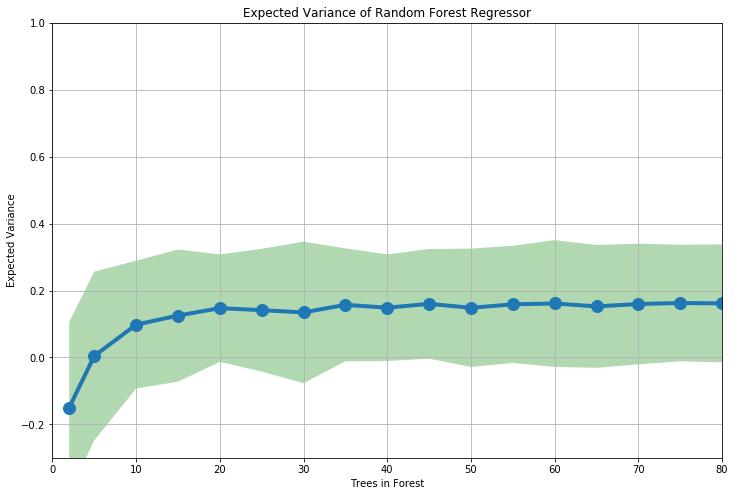

In [11]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

## Random Forests: A Slight Improvement a.k.a feature engineering
Yeah, the results are still absolutely awful. But, at least the estimated means for explained variance are positive, which is a small improvement. We probably need more features, considering how poor even heavily populated forests perform. Let's start by adding a few more features and seeing what happens...

In [12]:
# list all the features we want. This is still arbitrary...
included_features = ['MoSold','YrSold','LotArea','BedroomAbvGr', # original data
                    'FullBath','HalfBath','TotRmsAbvGrd', # bathrooms and total rooms
                    'YearBuilt','YearRemodAdd', # age of the house
                    'LotShape','Utilities'] # some categoricals 
# define the training data X...
X = train[included_features]
Y = train[['SalePrice']]
# and the data for the competition submission...
X_test = test[included_features]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
X.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,MoSold,YrSold,LotArea,BedroomAbvGr,FullBath,HalfBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,LotShape,Utilities
0,2,2008,8450,3,2,1,8,2003,2003,0,0
1,5,2007,9600,3,2,0,6,1976,1976,0,0
2,9,2008,11250,3,2,1,6,2001,2002,1,0
3,2,2006,9550,3,1,0,7,1915,1970,1,0
4,12,2008,14260,4,2,1,9,2000,2000,1,0


In [13]:
# define the number of estimators to consider
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']]
np.random.seed(11111)
# for each number of estimators, fit the model and find the results for 8-fold cross validation
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print("")
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: 0.58 (+/- 0.16)

estimators: 5
Est. explained variance: 0.67 (+/- 0.09)

estimators: 10
Est. explained variance: 0.69 (+/- 0.10)

estimators: 15
Est. explained variance: 0.69 (+/- 0.09)

estimators: 20
Est. explained variance: 0.70 (+/- 0.08)

estimators: 25
Est. explained variance: 0.70 (+/- 0.10)

estimators: 30
Est. explained variance: 0.71 (+/- 0.08)

estimators: 35
Est. explained variance: 0.71 (+/- 0.09)

estimators: 40
Est. explained variance: 0.71 (+/- 0.10)

estimators: 45
Est. explained variance: 0.72 (+/- 0.09)

estimators: 50
Est. explained variance: 0.71 (+/- 0.09)

estimators: 55
Est. explained variance: 0.71 (+/- 0.09)

estimators: 60
Est. explained variance: 0.72 (+/- 0.10)

estimators: 65
Est. explained variance: 0.72 (+/- 0.08)

estimators: 70
Est. explained variance: 0.71 (+/- 0.09)

estimators: 75
Est. explained variance: 0.72 (+/- 0.09)

estimators: 80
Est. explained variance: 0.71 (+/- 0.09)



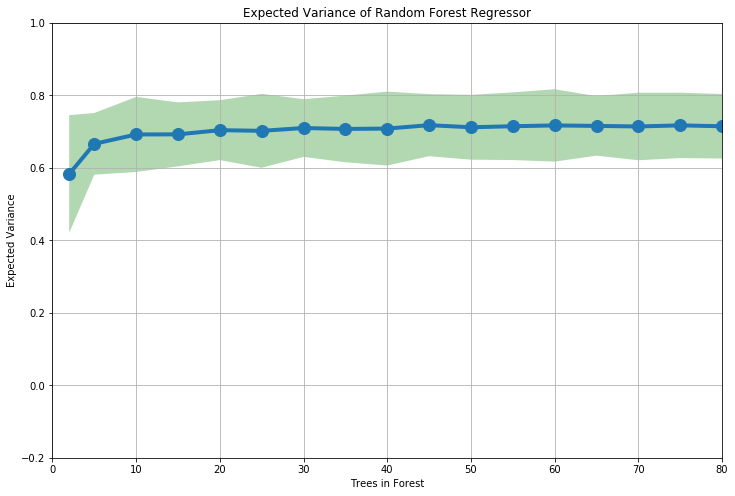

In [14]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([-.2,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

Clearly better, but still pretty bad. At least we are moving in the right direction (towards expected variance of 1).

## Scientific-ish Feature Analysis to Improve Random Forest Regressors
Let's stick with random forest regression for now, but let's try to be more scientific about the features we select for training the forests. Let's do some feature analysis.

First, let's collect all the available features and transform the categorical features where necessary....

In [16]:
import sklearn.feature_selection as fs # feature selection library in scikit-learn
train = pd.read_csv('train-2.csv') # get the training data again just in case
train['SalePrice'] = np.log(train['SalePrice'])
# first, let's include every feature that has data for all 1460 houses in the data set...
included_features = [col for col in list(train)
                    if len([i for i in train[col].T.notnull() if i == True])==1460
                    and col!='SalePrice' and col!='id']
# define the training data X...
X = train[included_features] # the feature data
Y = train[['SalePrice']] # the target
yt = [i for i in Y['SalePrice']] # the target list 
# and the data for the competition submission...
X_test = test[included_features]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
X.head()
# Y.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,0,8450,0,0,0,0,0,0,...,61,0,0,0,0,0,2,2008,0,0
1,2,20,0,9600,0,0,0,0,3,0,...,0,0,0,0,0,0,5,2007,0,0
2,3,60,0,11250,0,1,0,0,0,0,...,42,0,0,0,0,0,9,2008,0,0
3,4,70,0,9550,0,1,0,0,1,0,...,35,272,0,0,0,0,2,2006,0,2
4,5,60,0,14260,0,1,0,0,3,0,...,84,0,0,0,0,0,12,2008,0,0


## Mutual Information Regression Metric for Feature Ranking
We will use mutual information regression for feature ranking and selection. This metric measures the dependence between two random variables, in this case each feature in the data set and the sales price regression target. Note that this doesn't consider combinations of feature values (for example, the dependence between sales price and the year of sale combined with overall quality), which may also be useful.

See: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

In [17]:
mir_result = fs.mutual_info_regression(X, yt) # mutual information regression feature ordering
feature_scores = []
for i in np.arange(len(included_features)):
    feature_scores.append([included_features[i],mir_result[i]])
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


[['OverallQual' '0.5136381721742793']
 ['GrLivArea' '0.3703627611744371']
 ['GarageCars' '0.36306786180931905']
 ['KitchenQual' '0.3338163973982087']
 ['ExterQual' '0.3287640972504198']
 ['GarageArea' '0.2885644188969745']
 ['TotalBsmtSF' '0.2659845106806378']
 ['FullBath' '0.2622707877138404']
 ['1stFlrSF' '0.2619947306281647']
 ['YearBuilt' '0.2596084333686104']
 ['YearRemodAdd' '0.1960082277699473']
 ['Foundation' '0.19562658098485675']
 ['TotRmsAbvGrd' '0.1915020533249101']
 ['Fireplaces' '0.17031997732270887']
 ['HeatingQC' '0.16995592191050113']
 ['BsmtFinSF1' '0.13108811121442643']
 ['MSZoning' '0.12148616668761925']
 ['OverallCond' '0.11349373486797587']
 ['2ndFlrSF' '0.10867375088832265']
 ['LotShape' '0.0979153207264496']
 ['HalfBath' '0.08768083621946698']
 ['LotArea' '0.08751873685816003']
 ['SaleType' '0.07861772114711596']
 ['SaleCondition' '0.07460727173171389']
 ['BedroomAbvGr' '0.0676400172657381']
 ['CentralAir' '0.06392230608117333']
 ['MSSubClass' '0.062148659699976

## MIR Results: What do homebuyers care about?
Well, it seems like the most important factors (with respect to sales price) are overall quality, amount of living area, garage car capacity, kitchen quality, and exterior material quality. These seem like fairly intuitve results, at least for somebody with a distant notion of what matters when selecting a house (me).

Let's plot the results next to each other for a better visualization...

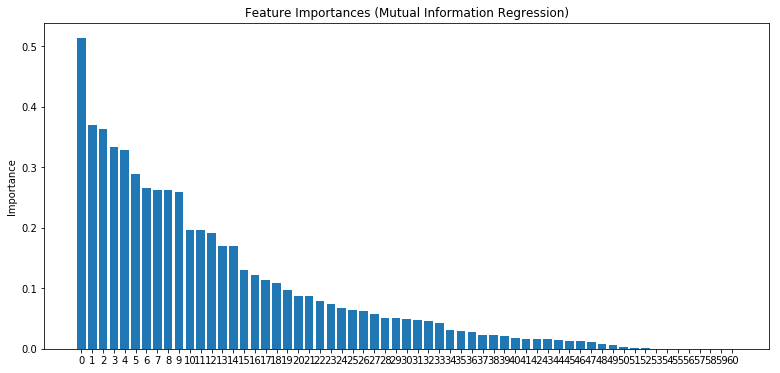

In [18]:
# and plot...
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features))
plt.bar(ind,[float(i) for i in np.array(sorted_scores)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
# plt.xlabel('Trees in Forest')
# plt.grid()
plt.show()

## Feature Pruning

Pruning is a technique in machine learning that reduces the size of decision trees by removing sections of the tree that provide little power to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.

It seems like the top few dozen features are fairly important... let's take the top 15, 20, 30, 40, and 50 features to train the random forest regressor model we've been working with and compare the performances. We will wrap the necessary model building and plotting code in functions first.

In [19]:
# define a function to do the necessary model building....
def getModel(sorted_scores,train,numFeatures):
    included_features = np.array(sorted_scores)[:,0][:numFeatures] # ordered list of important features
    # define the training data X...
    X = train[included_features]
    Y = train[['SalePrice']]
    # transform categorical data if included in X...
    for col in list(X):
        if X[col].dtype=='object':
            X = getObjectFeature(X, col)
    # define the number of estimators to consider
    estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
    mean_rfrs = []
    std_rfrs_upper = []
    std_rfrs_lower = []
    yt = [i for i in Y['SalePrice']]
    np.random.seed(11111)
    # for each number of estimators, fit the model and find the results for 8-fold cross validation
    for i in estimators:
        model = rfr(n_estimators=i,max_depth=None)
        scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
        mean_rfrs.append(scores_rfr.mean())
        std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
        std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting
    return mean_rfrs,std_rfrs_upper,std_rfrs_lower

# define a function to plot the model expected variance results...
def plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,numFeatures):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(estimators,mean_rfrs,marker='o',
           linewidth=4,markersize=12)
    ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                    facecolor='green',alpha=0.3,interpolate=True)
    ax.set_ylim([-.2,1])
    ax.set_xlim([0,80])
    plt.title('Expected Variance of Random Forest Regressor: Top %d Features'%numFeatures)
    plt.ylabel('Expected Variance')
    plt.xlabel('Trees in Forest')
    plt.grid()
    plt.show()
    return

...and let's run the regression model fitting for each of the scenarios listed before...

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


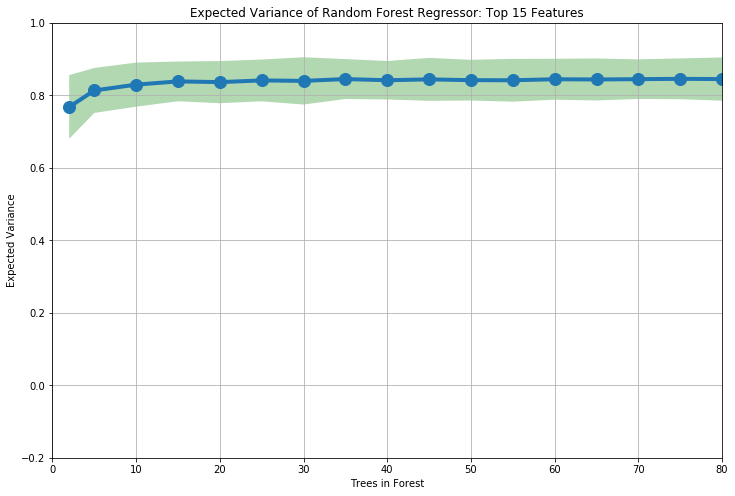

In [20]:
# top 15...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,15)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,15)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


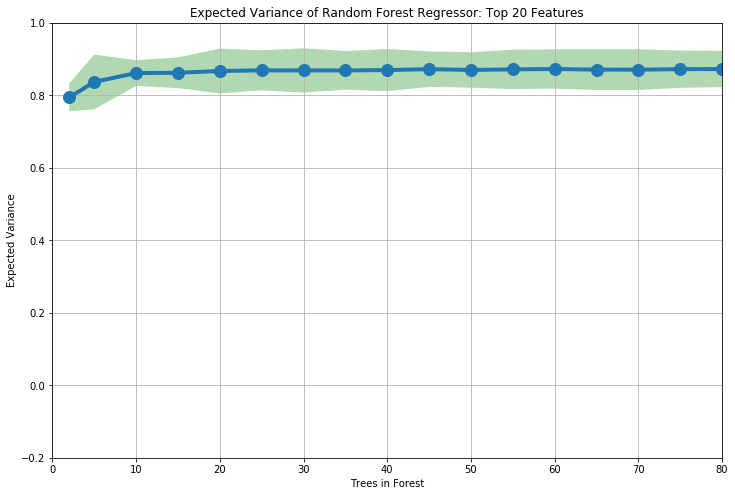

In [21]:
# top 20...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,20)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


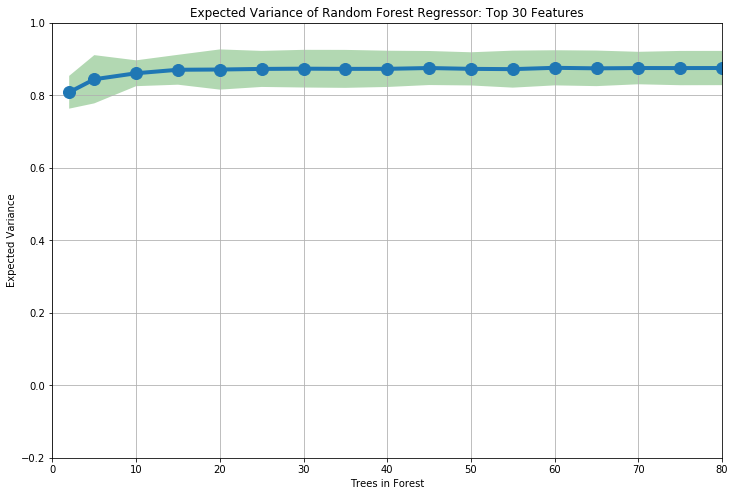

In [22]:
# top 30...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,30)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,30)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


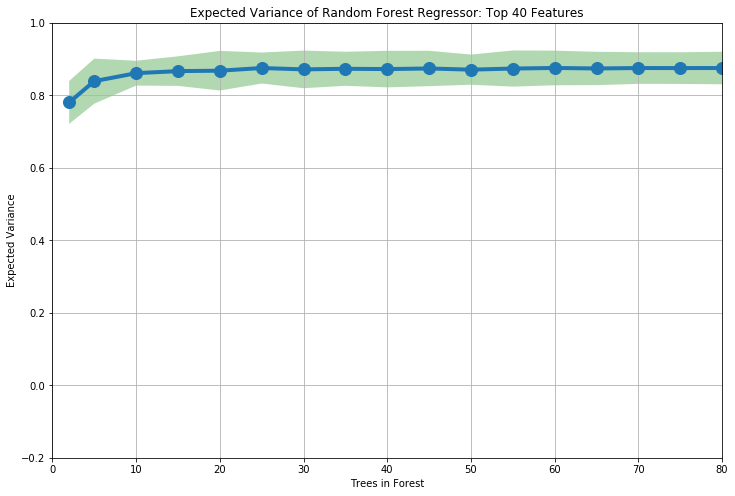

In [23]:
# top 40...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,40)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,40)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


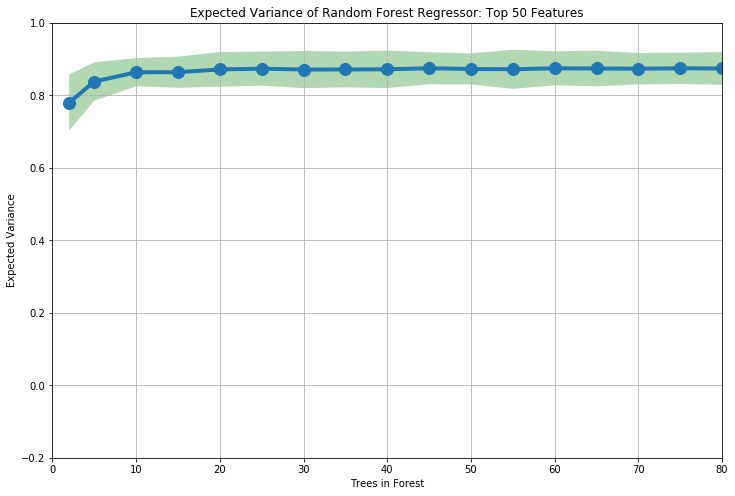

In [24]:
# top 50...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,50)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,50)

## Random Forest Regression Impressions

It seems like the mean expected variance of the regressions stops improving at around 20 features and 20 to 30 trees in the forest. The deviation in the expected variance score decreases with increasing features, which is intuitive. The 40-feature and 50-feature results look almost identical, probably because the 40th- to 50th-most important features are barely significant. Let's only consider the top 40 features from here on out.

## The Finale: Building the Output for Submission

Now, let's take the best regression model we have and build theoutput. For this model, we have:

. A random forest resgression model, incorporating
. the 40 most prominent features according to an MIR analysis, and
. 60 regressor trees per forest, and
. the default sklearn settings for the rest of the model parameters.
So let's apply this model to the test data and generate the submission!

In [25]:
# build the model with the desired parameters...
numFeatures = 40 # the number of features to inlcude
trees = 60 # trees in the forest
included_features = np.array(sorted_scores)[:,0][:numFeatures]
# define the training data X...
X = train[included_features]
Y = train[['SalePrice']]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
yt = [i for i in Y['SalePrice']]
np.random.seed(11111)
model = rfr(n_estimators=trees,max_depth=None)
scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
print('explained variance scores for k=10 fold validation:',scores_rfr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
# fit the model

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


explained variance scores for k=10 fold validation: [0.84304271 0.89696047 0.89515041 0.84035125 0.86654253 0.90106678
 0.88500114 0.9009358  0.851164   0.85945367]
Est. explained variance: 0.87 (+/- 0.05)


In [26]:
model.fit(X,yt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
# let's read the test data to be sure...
test = pd.read_csv('test-2.csv')

We will tweak the pre-processing function from before to handle missing data better, too.

In [28]:
# re-define a function to convert an object (categorical) feature into an int feature
# 0 = most common category, highest int = least common.
def getObjectFeature(df, col, datalength=1460):
    if df[col].dtype!='object': # if it's not categorical..
        print('feature',col,'is not an object feature.')
        return df
    else:
        df1 = df
        counts = df1[col].value_counts() # get the counts for each label for the feature
#         print(col,'labels, common to rare:',counts.index.tolist()) # get an ordered list of the labels
        df1[col] = [counts.index.tolist().index(i) 
                    if i in counts.index.tolist() 
                    else 0 
                    for i in df1[col] ] # do the conversion
        return df1 # make the new (integer) column from the conversion

In [29]:
# apply the model to the test data and get the output...
X_test = test[included_features]
for col in list(X_test):
    if X_test[col].dtype=='object':
        X_test = getObjectFeature(X_test, col, datalength=1459)
# print(X_test.head(20))
y_output = model.predict(X_test.fillna(0)) # get the results and fill nan's with 0
print(y_output)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[11.76822797 11.94919342 12.08405591 ... 11.96282689 11.66081124
 12.35694295]


In [30]:
# transform the data to be sure
y_output = np.exp(y_output)
print(y_output)

[129085.20499411 154692.32524098 177026.71044553 ... 156815.76003756
 115938.04625134 232569.16742414]


In [31]:
# define the data frame for the results
saleprice = pd.DataFrame(y_output, columns=['SalePrice'])
# print(saleprice.head())
# saleprice.tail()
results = pd.concat([test['Id'],saleprice['SalePrice']],axis=1)
results.head()

,Id,SalePrice
0,1461,129085.204994
1,1462,154692.325241
2,1463,177026.710446
3,1464,181290.564512
4,1465,191958.376230


### Conclusion : 

A kaggle regression dataset "House Prices" was picked and it was trained, tuned and its performance was evaluated using a random forest classifier.Techniques like mutual information regression(MIR) and feature pruning were used as feature importance calculations to perform the feature selection.

### Contribution Statement :

Performed the following tasks :

1. Loading of data.
2. Pre-processing of data.
3. Feature engineering/feature selection
4. Random forest regression technique

Code by self---40%
Code by reference---60%

### Citations :

Random Forest Classifier data---- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Titanic dataset reference ---- https://www.kaggle.com/c/titanic

Random Forest Classifier video reference---- https://www.youtube.com/watch?v=loNcrMjYh64

### License :

Copyright <2019> Ria Rajput Permission is hereby granted, free of charge, to any person obtaining a copy of this notebook and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.